initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=1000, dx=0.0010, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
ベンチマーク結果を読み込み: Conv_bench.pkl  (meta: {'saved_at': '2025-11-24T16:16:56', 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR', 'torch_version': '2.7.1+cu126', 'device': 'cuda', 'dtype': 'torch.float64', 'solver': None})
収束性テストの図を保存: Conv_bench.png


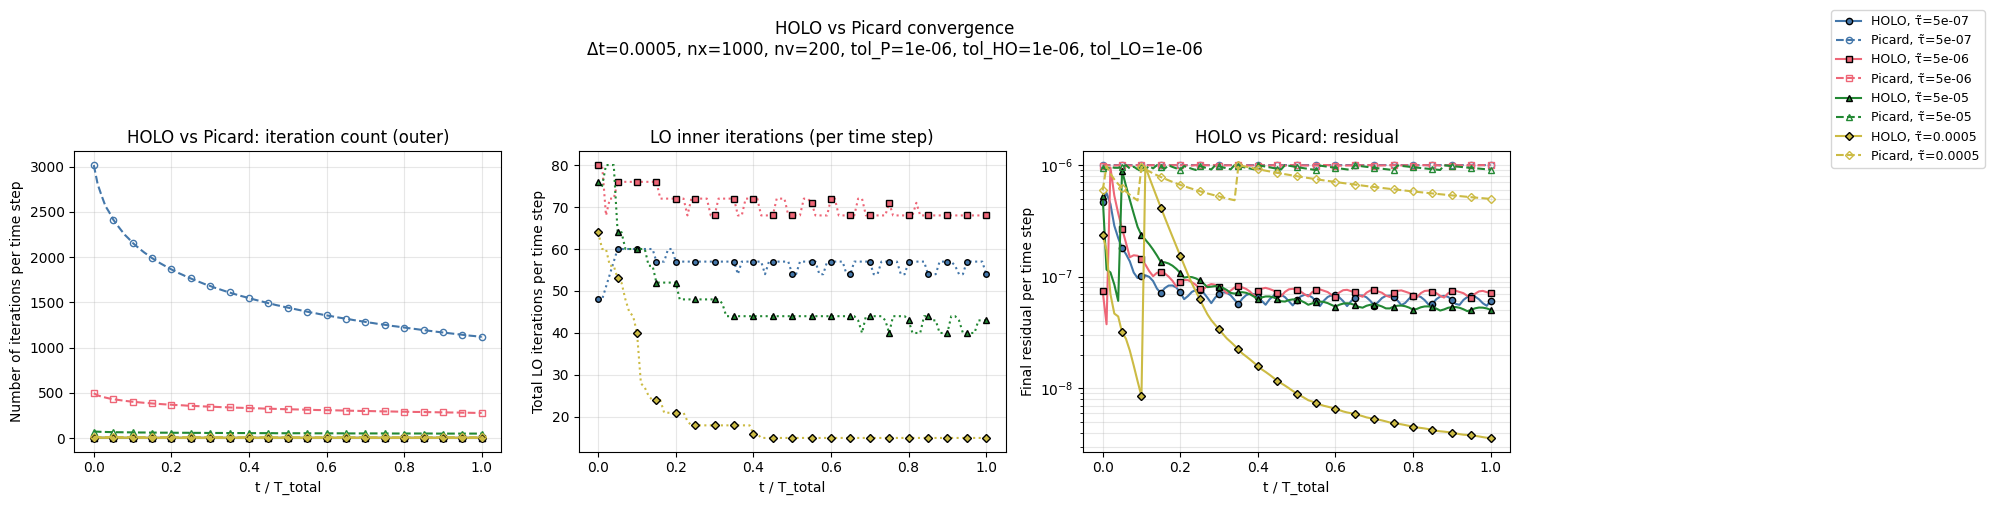

In [1]:
%run kineticEQ/tests/benchmarks/convergence_test.py --nv 200 --nx 1000 --picard_tol 1e-6 --ho_tol 1e-6 --lo_tol 1e-6 --no_run True